**Google-colabs:** https://colab.research.google.com/drive/19TUJHL5S6dVNajnW7zqVVChRxLz7vfhv?usp=sharing

In [1]:
import os
import glob
import shutil
import random
import time

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn, optim
from PIL import Image
from torchvision.transforms import Resize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


# Functions

In [2]:
class FetalPlaneDataset(Dataset):
    """Fetal Plane dataset."""

    def __init__(self,
                 root_dir,
                 csv_file,
                 plane=None,
                 brain_plane=None,
                 us_machine=None,
                 operator_number=None,
                 transform=None,
                 split_type=None,
                 split="train",
                 train_size=100,
                 downsampling_factor=2,
                 return_labels=False
                 ):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
            plane: 'Fetal brain'; 'Fetal thorax'; 'Maternal cervix'; 'Fetal femur'; 'Fetal thorax'; 'Other'
            brain_plane: 'Trans-ventricular'; 'Trans-thalamic'; 'Trans-cerebellum'
            us_machine: 'Voluson E6';'Voluson S10'
            operator_number: 'Op. 1'; 'Op. 2'; 'Op. 3';'Other'
            split_type (string, optional): Method to split dataset, supports "manual", and "csv"
            split (string): Which partition to return, supports "train", and "valid"
            train_size:  Limit dataset size to 100 images (for training)
            return_labels: Return the plane of the image

        return image, downsampled_image
        """
        self.transform = transform
        self.downsampling_factor = downsampling_factor
        self.root_dir = root_dir
        self.csv_file = pd.read_csv(csv_file, sep=';')
        self.return_labels = return_labels
        self.plane = plane

        if self.plane:
          self.csv_file = self.csv_file[self.csv_file['Plane'] == self.plane]
          if self.plane == 'Fetal brain':
            self.csv_file = self.csv_file[self.csv_file['Brain_plane'] != 'Other']
        if brain_plane:
            self.csv_file = self.csv_file[self.csv_file['Brain_plane'] == brain_plane]
        if us_machine is not None:
            self.csv_file = self.csv_file[self.csv_file['US_Machine'] == us_machine]
        if operator_number is not None:
            self.csv_file = self.csv_file[self.csv_file['Operator'] == operator_number]

        self.train_size = train_size

        # Split data manually
        if split_type == "manual":
            if split == "train":
                self.csv_file = self.csv_file[:self.train_size]
            elif split == "valid":
                self.csv_file = self.csv_file[self.train_size:]
        # Split data according to CSV
        elif split_type == "csv":
            if split == "train":
                self.csv_file = self.csv_file[self.csv_file['Train '] == 1]
            elif split == "valid":
                self.csv_file = self.csv_file[self.csv_file['Train '] == 0]

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # Load the image from file

        # print(f'idx: {idx} \n')
        # print(f'self.csv_file.iloc[idx, 0]: {self.csv_file.iloc[idx, 0]} \n')

        img_name = os.path.join(self.root_dir,
                                self.csv_file.iloc[idx, 0] + '.png')
        # print(img_name)
        image = Image.open(img_name)  # <class 'numpy.ndarray'>

        # print(type(image))
        # print(image.dtype)

        # Preprocess and augment the image
        if self.transform:
            image = self.transform(image)

        ## Downsample image for SRGAN
        size = image.size()
        tr_resize = Resize((int(size[1] / self.downsampling_factor), int(size[2] / self.downsampling_factor)))
        ds_image = tr_resize(image)
        # .cpu().numpy()#TypeError: Cannot interpret 'torch.float32' as a data type

        # Return labels for classification task
        if self.return_labels:
            if self.plane == 'Fetal brain':
              im_plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 3]), axis=0)
              if im_plane == 'Trans-thalamic':
                im_plane = 0
              elif im_plane == 'Trans-ventricular':
                im_plane = 1
              elif im_plane == 'Trans-cerebellum':
                im_plane = 2
            else:
              im_plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 2]), axis=0)
              if im_plane == 'Other':
                  im_plane = 0
              elif im_plane == 'Fetal brain':
                  im_plane = 1
              elif im_plane == 'Fetal abdomen':
                  im_plane = 2
              elif im_plane == 'Fetal femur':
                  im_plane = 3
              elif im_plane == 'Fetal thorax':
                  im_plane = 4
              elif im_plane == 'Maternal cervix':
                  im_plane = 4
            return image, im_plane
        else:
            return image, ds_image


class AfricanFetalPlaneDataset(Dataset):
    """African Fetal Plane dataset."""

    def __init__(self,
                 root_dir,
                 csv_file,
                 plane=None,
                 country=None,
                 transform=None,
                 split_type=None,
                 split="Train",
                 train_size=100,
                 downsampling_factor=2,
                 return_labels=False
                 ):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            plane: 'Fetal brain', 'Fetal abdomen','Fetal femur', 'Fetal thorax'
            country: 'Algeria', 'Egypt', 'Malawi', 'Uganda', 'Ghana'
            transform (callable, optional): Optional transform to be applied on a sample.
            split_type (string, optional): Method to split dataset, supports "manual", and "csv"
            split (string): Which partition to return, supports "train", and "valid"
            train_size:  Limit dataset size to 100 images (for training)
            downsampling_factor: downsampling image
            return_labels: Return the plane and country of the image

        return image, downsampled_image
        """
        self.transform = transform
        self.downsampling_factor = downsampling_factor
        self.root_dir = root_dir
        self.plane = plane
        self.country = country
        self.csv_file = pd.read_csv(csv_file, sep=',')
        self.return_labels = return_labels

        if self.plane is not None:
            self.csv_file = self.csv_file[self.csv_file['Plane'] == self.plane]
        if self.country is not None:
            self.csv_file = self.csv_file[self.csv_file['Center'] == self.country]

        # Split data manually
        if split_type == "manual":
            if split == "train":
                self.csv_file = self.csv_file[:train_size]
            elif split == "valid":
                self.csv_file = self.csv_file[train_size:]
        # Split data according to CSV
        elif split_type == "csv":
            if split == "train":
                self.csv_file = self.csv_file[self.csv_file['Train'] == 1]
            elif split == "valid":
                self.csv_file = self.csv_file[self.csv_file['Train'] == 0]

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # Load the random image from file

        # print(f'idx: {idx} \n')
        # print(f'self.csv_file.iloc[idx, 4]: {self.csv_file.iloc[idx, 4]} \n')#Filename

        img_name = os.path.join(self.root_dir,
                                self.csv_file.iloc[idx, 4] + '.png') #Filename
        image = Image.open(img_name)  # <class 'numpy.ndarray'>

        # print(type(image))
        # print(image.dtype)

        if self.transform:
            image = self.transform(image)

        ## Downsample image for SRGAN
        size = image.size()
        tr_resize = Resize((int(size[1] / self.downsampling_factor), int(size[2] / self.downsampling_factor)))
        ds_image = tr_resize(image)

        # Return labels for classification task
        if self.return_labels:
            plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 1]), axis=0)
            if plane == 'Fetal brain':
                plane = 0
            elif plane == 'Fetal abdomen':
                plane = 1
            elif plane == 'Fetal femur':
                plane = 2
            elif plane =='Fetal thorax':
                plane = 3
            return image, plane

        else:
            return image, ds_image

In [3]:
def save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, save_path):
  state = {
    'epoch': epoch,
    'best_epoch': best_epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
  }
  torch.save(state, save_path)

def load_model(model_path, device, model=None, optimizer=None):
  if device == "cpu":
    state = torch.load(model_path, map_location=torch.device('cpu'))
  else:
    state = torch.load(model_path)

  epoch = state['epoch']
  best_epoch = state['best_epoch']
  train_losses = state['train_losses']
  val_losses = state['val_losses']

  if model:
    model.load_state_dict(state['state_dict'])
  if optimizer:
    optimizer.load_state_dict(state['optimizer'])

  return epoch, best_epoch, model, optimizer, train_losses, val_losses


def train_model(train_dataloader, 
                val_dataloader, 
                model, 
                optimizer, 
                num_epochs, 
                model_save_path, 
                checkpoint_save_path, 
                device, 
                load_checkpoint=False):
  start = time.time()
  train_losses = []
  val_losses = []
  best_loss = 100
  best_epoch = 0
  s_epoch = 0

  if load_checkpoint:
    s_epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(checkpoint_save_path, device, model, optimizer)
    best_loss = val_losses[best_epoch]

  #TODO add if to print or not model
  # print(model)
  for epoch in range(s_epoch, num_epochs):
    model.train()
    running_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels).mean()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 10 == 0:
        print(f"Epoch {epoch} iteration {i} training loss: {loss.item()}")

    train_epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)


    model.eval()
    with torch.no_grad():
      running_loss = 0
      for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels).mean()
        running_loss += loss.item()
      val_epoch_loss = running_loss / len(val_dataloader)
      val_losses.append(val_epoch_loss)
      if epoch == 0:
        best_loss = val_epoch_loss
      elif val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        best_epoch = epoch
        save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, model_save_path)

      save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, checkpoint_save_path)
      print(f"Epoch {epoch} average training loss: {train_epoch_loss}, average validation loss: {val_epoch_loss}")
      end = time.time()
      print(f"Running time: {end - start}s")
  end = time.time()
  print(f"Execution time: {end - start}s")

In [4]:
def plot_training_curve(train_losses, val_losses, best_epoch=None, title=None):
  plt.plot(train_losses, label="Train")
  plt.plot(val_losses, label="Test")
  if title:
    plt.title(title)
  if best_epoch:
    plt.axvline(x=best_epoch, color='#9f9f9f', label=(f"Best Epoch: {best_epoch}"), ls="--", lw=1)
  plt.legend()
  plt.show()

def evaluate_model(y_true, y_pred, class_names):
  accuracy = accuracy_score(y_true, y_pred)
  p, r, f, s = precision_recall_fscore_support(y_true, y_pred)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {p}")
  print(f"Recall: {r}")
  print(f"F1: {f}")
  print(f"Support: {s}")

  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names)
  plt.show()



# Fetal Plane Dataset

In [6]:
# !unzip /content/drive/MyDrive/FETAL_PLANES_ZENODO.zip -d /content/drive/MyDrive/fetalplane_dataset
# DATA_PATH="/content/drive/MyDrive/african_dataset/Images"
DATA_PATH="/home/mxochicale/datasets/FETAL_PLANES_DB_2020"




## Train Brain Planes (`plane='Fetal brain'`)

In [25]:
## TO CHECK. This seems to be the whole dataset #(6416, 713, 5271) oiringal 
# image_size = 500
# transform_operations=transforms.Compose([
#                         #mt.RandRotate(range_x=0.1, prob=0.5),
#                         #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
#                         #mt.Resize([image_size, image_size]),
#                         transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
#                         transforms.ToTensor(),
#                         transforms.Resize([image_size, image_size], antialias=True),
#                         transforms.Normalize((0.5), (0.5)),
#                         ])

# fetalplane_train_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
#                                            "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
#                                            transform=transform_operations,
#                                            return_labels=True,
#                                            split_type="csv",
#                                            split="train")
# fetalplane_test_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
#                                            "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
#                                            transform=transform_operations,
#                                            return_labels=True,
#                                            split_type="csv",
#                                            split="valid")
# train_size = int(0.9 * len(fetalplane_train_dataset))
# val_size = len(fetalplane_train_dataset) - train_size
# fetalplane_train_dataset, fetalplane_val_dataset = torch.utils.data.random_split(fetalplane_train_dataset, [train_size, val_size])
# print((len(fetalplane_train_dataset), len(fetalplane_val_dataset), len(fetalplane_test_dataset)))
#(6416, 713, 5271) oiringal 

In [33]:
DATA_IMAGES=DATA_PATH+"/Images"
DATA_DB_CSV=DATA_PATH+"/FETAL_PLANES_DB_data.csv"

image_size = 128
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

brainplane_train_dataset = FetalPlaneDataset(DATA_IMAGES,
                                           DATA_DB_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane='Fetal brain',
                                           split_type="csv",
                                           split="train")
brainplane_val_dataset = FetalPlaneDataset(DATA_IMAGES,
                                           DATA_DB_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane='Fetal brain',
                                           split_type="csv",
                                           split="valid")
# train_size = int(0.9 * len(fetalplane_train_dataset))
# val_size = len(fetalplane_train_dataset) - train_size
# fetalplane_train_dataset, fetalplane_val_dataset = torch.utils.data.random_split(fetalplane_train_dataset, [train_size, val_size])
print((len(brainplane_train_dataset), len(brainplane_val_dataset)))


# (1543, 1406) original 

(1543, 1406)


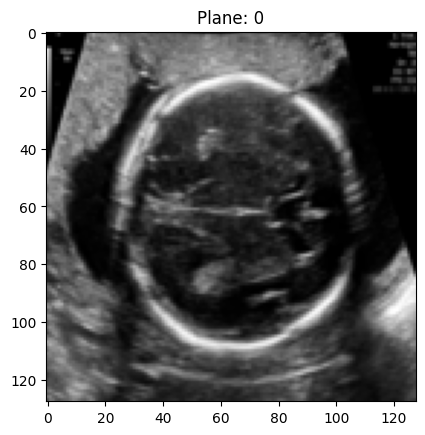

In [34]:
train_dataloader = DataLoader(brainplane_train_dataset, batch_size=32, shuffle="True")
val_dataloader = DataLoader(brainplane_val_dataset, batch_size=32)

ims, planes = next(iter(train_dataloader))
for i, p in list(zip(ims, planes)):
    plt.imshow(i[0], cmap="gray")
    plt.title(f"Plane: {p}")
    plt.show()
    break

In [35]:
bp_model = models.densenet169(pretrained=True)
num_features = bp_model.classifier.in_features
bp_model.fc = nn.Linear(num_features, 3)
bp_model = bp_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bp_model.parameters(), lr=0.001)

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
num_epochs=3
# num_epochs = 200

# model_save_path = '/content/drive/MyDrive/xfetus/models/fp_clf.pt'#shoult it BP
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/fp_ckpt.pt' #should be BP
model_save_path = DATA_PATH+'/models/bp_clf.pt'
checkpoint_save_path = DATA_PATH+'/models/bp_ckpt.pt'

if not os.path.exists(DATA_PATH+"/models"):
    os.mkdir(DATA_PATH+"/models")

train_model(train_dataloader,
            val_dataloader,
            bp_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device,
            load_checkpoint=True
            )


Epoch 0 iteration 0 training loss: 10.721175193786621
Epoch 0 iteration 10 training loss: 0.8536871671676636
Epoch 0 iteration 20 training loss: 0.6781952977180481
Epoch 0 iteration 30 training loss: 0.6040005683898926
Epoch 0 iteration 40 training loss: 0.5591895580291748
Epoch 0 average training loss: 1.3134810249416196, average validation loss: 0.9906406490640207
Running time: 220.2689986228943s
Epoch 1 iteration 0 training loss: 0.35640937089920044
Epoch 1 iteration 10 training loss: 0.3998638391494751
Epoch 1 iteration 20 training loss: 0.4189837574958801
Epoch 1 iteration 30 training loss: 0.4143034815788269
Epoch 1 iteration 40 training loss: 0.30287134647369385
Epoch 1 average training loss: 0.4236542336186584, average validation loss: 0.5879547108303417
Running time: 435.7575900554657s
Epoch 2 iteration 0 training loss: 0.24013260006904602
Epoch 2 iteration 10 training loss: 0.44024017453193665
Epoch 2 iteration 20 training loss: 0.3540809750556946
Epoch 2 iteration 30 trainin

## Train 80/20 Brain Planes

In [16]:
# Split dataset 80/20

# DATA_IMAGES=DATA_PATH+"/Images"
DATA_DB_CSV=DATA_PATH+"/FETAL_PLANES_DB_data.csv"
DATA_DB_CSV8020=DATA_PATH+"/FETAL_PLANES_DB_data_8020.csv"


# Load csv
fetal_plane_dataset_csv = pd.read_csv(DATA_DB_CSV, delimiter=";")

# Get number of train and val
train_data = fetal_plane_dataset_csv.loc[fetal_plane_dataset_csv['Train ']==1]
val_data = fetal_plane_dataset_csv.loc[fetal_plane_dataset_csv['Train ']==0]
train_patient_num = train_data["Patient_num"].nunique()
val_patient_num = val_data["Patient_num"].nunique()
print(f"Number of patients in train {train_patient_num}, val {val_patient_num}")


# Get values for splitting
val_split = round((train_patient_num + val_patient_num) * 0.2)
train_split = round((train_patient_num + val_patient_num) * 0.8)
print(f"For 80/20 split, number of patients in train {train_split}, val {val_split}")
num_convert = train_split - train_patient_num
print(f"Number of validation images to convert {num_convert}")

# Convert validation to train
val_patient = val_data["Patient_num"].unique()
random.shuffle(val_patient)
for patient in val_patient[:num_convert]:
  fetal_plane_dataset_csv.loc[fetal_plane_dataset_csv["Patient_num"] == patient, "Train "] = 1

# Check all worked correctly
new_train_data = fetal_plane_dataset_csv.loc[fetal_plane_dataset_csv['Train ']==1]
new_val_data = fetal_plane_dataset_csv.loc[fetal_plane_dataset_csv['Train ']==0]

new_train_patient_num = new_train_data["Patient_num"].nunique()
new_val_patient_num = new_val_data["Patient_num"].nunique()

print(f"New number of patients in train {new_train_patient_num}, val {new_val_patient_num}")

# Save new csv
fetal_plane_dataset_csv.to_csv(DATA_DB_CSV8020, index=False,sep=";")

print("Train", new_train_data["Plane"].value_counts())
print("Val", new_val_data["Plane"].value_counts())

##LOGS
# Number of patients in train 896, val 896
# For 80/20 split, number of patients in train 1434, val 358
# Number of validation images to convert 538
# New number of patients in train 1434, val 358
# Train Other              3580
# Fetal brain        2502
# Fetal thorax       1452
# Maternal cervix    1367
# Fetal femur         832
# Fetal abdomen       580
# Name: Plane, dtype: int64
# Val Other              633
# Fetal brain        590
# Fetal thorax       266
# Maternal cervix    259
# Fetal femur        208
# Fetal abdomen      131
# Name: Plane, dtype: int64

Number of patients in train 896, val 896
For 80/20 split, number of patients in train 1434, val 358
Number of validation images to convert 538
New number of patients in train 1434, val 358
Train Plane
Other              3532
Fetal brain        2418
Fetal thorax       1435
Maternal cervix    1369
Fetal femur         810
Fetal abdomen       551
Name: count, dtype: int64
Val Plane
Other              681
Fetal brain        674
Fetal thorax       283
Maternal cervix    257
Fetal femur        230
Fetal abdomen      160
Name: count, dtype: int64


In [17]:
DATA_IMAGES=DATA_PATH+"/Images"
DATA_DB_CSV=DATA_PATH+"/FETAL_PLANES_DB_data_8020.csv"

image_size = 128
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

brainplane_train_dataset = FetalPlaneDataset(DATA_IMAGES,
                                           DATA_DB_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane='Fetal brain',
                                           split_type="csv",
                                           split="train")
brainplane_val_dataset = FetalPlaneDataset(DATA_IMAGES,
                                           DATA_DB_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane='Fetal brain',
                                           split_type="csv",
                                           split="valid")
# train_size = int(0.9 * len(fetalplane_train_dataset))
# val_size = len(fetalplane_train_dataset) - train_size
# fetalplane_train_dataset, fetalplane_val_dataset = torch.utils.data.random_split(fetalplane_train_dataset, [train_size, val_size])
print((len(brainplane_train_dataset), len(brainplane_val_dataset)))
#original (2390, 559)

(2309, 640)


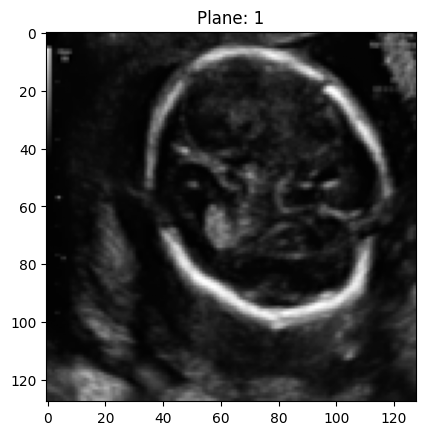

In [18]:
train_dataloader = DataLoader(brainplane_train_dataset, batch_size=32, shuffle="True")
val_dataloader = DataLoader(brainplane_val_dataset, batch_size=32)

ims, planes = next(iter(train_dataloader))
for i, p in list(zip(ims, planes)):
    plt.imshow(i[0], cmap="gray")
    plt.title(f"Plane: {p}")
    plt.show()
    break

In [19]:
bp_model = models.densenet169(pretrained=True)
num_features = bp_model.classifier.in_features
bp_model.fc = nn.Linear(num_features, 3)
bp_model = bp_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bp_model.parameters(), lr=0.001)

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
num_epochs = 3
# num_epochs = 100

# model_save_path = '/content/drive/MyDrive/xfetus/models/bp_clf_8020.pt'
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/bp_ckpt_8020.pt'
model_save_path = DATA_PATH+'/models/bp_clf_8020.pt'
checkpoint_save_path = DATA_PATH+'/models/bp_ckpt_8020.pt'


train_model(train_dataloader,
            val_dataloader,
            bp_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device,
            load_checkpoint=True)

/tmp/ipykernel_33882/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 2 iteration 0 training loss: 0.2526678740978241
Epoch 2 iteration 10 training loss: 0.2375783771276474
Epoch 2 iteration 20 training loss: 0.3964024484157562
Epoch 2 iteration 30 training loss: 0.23774456977844238
Epoch 2 iteration 40 training loss: 0.21856801211833954
Epoch 2 iteration 50 training loss: 0.2654474377632141
Epoch 2 iteration 60 training loss: 0.4576435685157776
Epoch 2 iteration 70 training loss: 0.5994526743888855
Epoch 2 average training loss: 0.3537391195558522, average validation loss: 0.5092963464558125
Running time: 219.92549896240234s
Execution time: 219.92559504508972s


## Train Fetal Planes (`plane=None`)

In [26]:
DATA_IMAGES=DATA_PATH+"/Images"
DATA_DB_CSV=DATA_PATH+"/FETAL_PLANES_DB_data.csv"

image_size = 128
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

fetalplane_train_dataset = FetalPlaneDataset(DATA_IMAGES,
                                           DATA_DB_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane=None,
                                           split_type="csv",
                                           split="train")
fetalplane_val_dataset = FetalPlaneDataset(DATA_IMAGES,
                                           DATA_DB_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane=None,
                                           split_type="csv",
                                           split="valid")
# train_size = int(0.9 * len(fetalplane_train_dataset))
# val_size = len(fetalplane_train_dataset) - train_size
# fetalplane_train_dataset, fetalplane_val_dataset = torch.utils.data.random_split(fetalplane_train_dataset, [train_size, val_size])
print((len(fetalplane_train_dataset), len(fetalplane_val_dataset)))

#(7129, 5271) oriingal

(7129, 5271)


In [27]:
train_dataloader = DataLoader(fetalplane_train_dataset, batch_size=32, shuffle="True")
val_dataloader = DataLoader(fetalplane_val_dataset, batch_size=32)

In [28]:
fp_model = models.densenet169(pretrained=True)
num_features = fp_model.classifier.in_features
fp_model.fc = nn.Linear(num_features, 3)
fp_model = fp_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fp_model.parameters(), lr=0.001)

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:

# ckpt = torch.load('/content/drive/MyDrive/xfetus/checkpoints/fp_ckpt.pt')
ckpt = torch.load(DATA_PATH+'/models/fp_ckpt.pt')
fp_model.load_state_dict(ckpt['state_dict'])
optimizer.load_state_dict(ckpt['optimizer'])


/tmp/ipykernel_33882/2730956164.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(DATA_PATH+'/models/fp_ckpt.pt')


In [30]:
num_epochs = 3
# num_epochs = 100
# model_save_path = '/content/drive/MyDrive/xfetus/models/fp_clf.pt'
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/fp_ckpt.pt'
model_save_path = DATA_PATH+'/models/fp_clf.pt'
checkpoint_save_path = DATA_PATH+'/models/fp_ckpt.pt'

train_model(train_dataloader,
            val_dataloader,
            fp_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device,
            load_checkpoint=True)

/tmp/ipykernel_33882/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 2 iteration 0 training loss: 8.997415542602539
Epoch 2 iteration 10 training loss: 1.1644805669784546
Epoch 2 iteration 20 training loss: 1.1131690740585327
Epoch 2 iteration 30 training loss: 0.4101586639881134
Epoch 2 iteration 40 training loss: 0.35699525475502014
Epoch 2 iteration 50 training loss: 0.7119539976119995
Epoch 2 iteration 60 training loss: 0.7007699012756348
Epoch 2 iteration 70 training loss: 0.5417423844337463
Epoch 2 iteration 80 training loss: 0.4934781491756439
Epoch 2 iteration 90 training loss: 0.33011484146118164
Epoch 2 iteration 100 training loss: 0.25797462463378906
Epoch 2 iteration 110 training loss: 0.1308688521385193
Epoch 2 iteration 120 training loss: 0.2542542517185211
Epoch 2 iteration 130 training loss: 0.463662326335907
Epoch 2 iteration 140 training loss: 0.4962179660797119
Epoch 2 iteration 150 training loss: 0.22516848146915436
Epoch 2 iteration 160 training loss: 0.24994292855262756
Epoch 2 iteration 170 training loss: 0.3831738829612732


## Evaluate Brain Planes

In [38]:
# model_save_path = '/content/drive/MyDrive/xfetus/models/bp_clf.pt'
model_save_path = DATA_PATH+'/models/bp_clf.pt'

bp_model = models.densenet169(pretrained=True)
num_features = bp_model.classifier.in_features
bp_model.fc = nn.Linear(num_features, 3)
bp_model = bp_model.to(device)

epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, bp_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

/tmp/ipykernel_33882/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Loaded model from best epoch 1 with validation loss: 0.5879547108303417


/tmp/ipykernel_33882/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


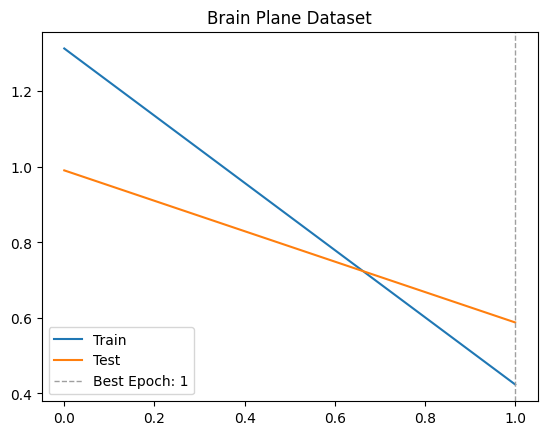

In [39]:
bp_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    inputs = inputs.to(device)
    outputs = bp_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))

# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/bp_ckpt.pt'
checkpoint_save_path = DATA_PATH+'/models/bp_clf.pt'

_, _, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "Brain Plane Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

Accuracy: 0.7652916073968705
Precision: [0.8459168  0.63116883 0.76344086]
Recall: [0.71764706 0.80463576 0.83775811]
F1: [0.77652051 0.70742358 0.79887482]
Support: [765 302 339]


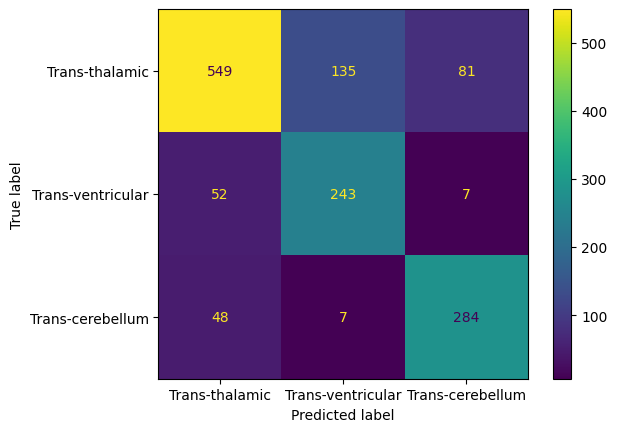

In [40]:
class_names = ['Trans-thalamic', 'Trans-ventricular', 'Trans-cerebellum']
evaluate_model(label_list, pred_list, class_names)